In [ ]:
import os
import math
import cv2 as cv
import numpy as np
import random as rn
import pandas as pd
import imagesize as im
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
FOLDER = r'anomalib\src\anomalib\models\patchcore\patchcore_data2'
TRAIN_SAMPLES = 75
VAL_SAMPLES = 25
IMG_H, IMG_W, IMG_C = 256, 256, 3
BATCH_SIZE = 8
WORKERS = 2
EPOCHS = 100
MASK_FOLDER = r'mask\oring_absent'
NORMAL_FOLDER = 'oring_present'
ABNORMAL_FOLDER = 'oring_absent'

In [ ]:
normal = [os.path.join(FOLDER, NORMAL_FOLDER, i) for i in sorted(os.listdir(os.path.join(FOLDER, NORMAL_FOLDER)))]
abnormal = [os.path.join(FOLDER, ABNORMAL_FOLDER, i) for i in sorted(os.listdir(os.path.join(FOLDER, ABNORMAL_FOLDER)))]
abnormal_mask = [os.path.join(FOLDER, MASK_FOLDER, i) for i in sorted(os.listdir(os.path.join(FOLDER, MASK_FOLDER)))]
len(normal), len(abnormal), len(abnormal_mask)

In [ ]:
train_normal = normal[:TRAIN_SAMPLES]
train_abnormal = abnormal[:TRAIN_SAMPLES]
train_normal_mask = [None for _ in train_normal]
train_abnormal_mask = abnormal_mask[:TRAIN_SAMPLES]
train_df = pd.DataFrame({'image': train_normal + train_abnormal, 'mask': train_normal_mask + train_abnormal_mask})
val_normal = normal[TRAIN_SAMPLES: TRAIN_SAMPLES + VAL_SAMPLES]
val_abnormal = abnormal[TRAIN_SAMPLES: TRAIN_SAMPLES + VAL_SAMPLES]
val_normal_mask = [None for _ in val_normal]
val_abnormal_mask = abnormal_mask[TRAIN_SAMPLES: TRAIN_SAMPLES + VAL_SAMPLES]
val_df = pd.DataFrame({'image': val_normal + val_abnormal, 'mask': val_normal_mask + val_abnormal_mask})
val_df.head()

In [ ]:
class Pipeline(tf.keras.utils.Sequence):
    def __init__(self, dataframe, xcol, ycol, batch_size, img_h, img_w, img_c):
        super(Pipeline, self).__init__()
        self.dataframe = dataframe
        self.xcol = xcol
        self.ycol = ycol
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.img_c = img_c

    def __len__(self):
        return math.floor(self.dataframe.shape[0] / self.batch_size)

    def on_epoch_end(self):
        self.dataframe = self.dataframe.sample(frac=1)
        self.dataframe.reset_index(drop=True, inplace=True)

    def __getitem__(self, index):
        X = self.dataframe[self.xcol][index * self.batch_size: (index + 1) * self.batch_size].to_list()
        X = [cv.imread(i) for i in X]
        X = [cv.cvtColor(i, cv.COLOR_BGR2RGB) for i in X]
        X = [cv.resize(i, (self.img_w, self.img_h)) for i in X]
        X = [np.array(i, dtype='float32') for i in X]
        X = [np.expand_dims(i, axis=0) for i in X]
        X = [i / 255.0 for i in X]
        X = np.concatenate(X, axis=0)
        Y = self.dataframe[self.ycol][index * self.batch_size: (index + 1) * self.batch_size].to_list()
        Y = [cv.imread(i) if i is not None else np.zeros(shape=(self.img_h, self.img_w, self.img_c), dtype='uint8') for i in Y]
        Y = [cv.cvtColor(i, cv.COLOR_BGR2GRAY) for i in Y]
        Y = [cv.resize(i, (self.img_w, self.img_h)) for i in Y]
        Y = [np.array(i, dtype='float32') for i in Y]
        Y = [np.expand_dims(i, axis=-1) for i in Y]
        Y = [np.expand_dims(i, axis=0) for i in Y]
        Y = [i / 255.0 for i in Y]
        Y = np.concatenate(Y, axis=0)
        return tf.convert_to_tensor(X), tf.convert_to_tensor(Y)
train_gen = Pipeline(train_df, 'image', 'mask', BATCH_SIZE, IMG_H, IMG_W, IMG_C)
val_gen = Pipeline(val_df, 'image', 'mask', BATCH_SIZE, IMG_H, IMG_W, IMG_C)
x, y = val_gen[0]
x.shape, y.shape

In [ ]:
X_inp = tf.keras.Input(shape=(IMG_H, IMG_W, IMG_C), batch_size=BATCH_SIZE)
base = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=X_inp)
s1 = base.get_layer('block1_conv2').output
s2 = base.get_layer('block2_conv2').output
s3 = base.get_layer('block3_conv4').output
s4 = base.get_layer('block4_conv4').output
s5 = base.get_layer('block5_conv4').output
X = base.output
X = tf.keras.layers.Conv2D(1024, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s5])
X = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s4])
X = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s3])
X = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s2])
X = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s1])
X = tf.keras.layers.Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(X)
model = tf.keras.Model(inputs=X_inp, outputs=X)
model.summary()

In [ ]:
class CustomMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes):
        super(CustomMetric, self).__init__(name='custom_metric', dtype=tf.float32)
        self.num_classes = num_classes
        self.p = self.add_weight(name='precision', initializer='zeros')
        self.r = self.add_weight(name='recall', initializer='zeros')
        self.a = self.add_weight(name='accuracy', initializer='zeros')
        self.f = self.add_weight(name='f1', initializer='zeros')
        self.s = self.add_weight(name='sample', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.math.round(y_true)
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.math.round(y_pred)
        y_pred = tf.reshape(y_pred, shape=[-1])

        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes)
        cm = tf.cast(cm, dtype=tf.float32)

        tp = tf.linalg.diag_part(cm)
        tp_fp = tf.reduce_sum(cm, axis=-1)
        tp_fn = tf.reduce_sum(cm, axis=0)

        prec = tp / tp_fp
        rec = tp / tp_fn
        acc = tf.reduce_sum(tp) / tf.reduce_sum(cm)
        f1 = (2 * prec * rec) / (prec + rec)

        prec = tf.where(tf.math.is_nan(prec), 0.0, prec)
        rec = tf.where(tf.math.is_nan(rec), 0.0, rec)
        acc = tf.where(tf.math.is_nan(acc), 0.0, acc)
        f1 = tf.where(tf.math.is_nan(f1), 0.0, f1)

        mean_prec = tf.reduce_mean(prec)
        mean_rec = tf.reduce_mean(rec)
        mean_f1 = tf.reduce_mean(f1)

        self.p.assign_add(mean_prec)
        self.r.assign_add(mean_rec)
        self.a.assign_add(acc)
        self.f.assign_add(mean_f1)
        self.s.assign_add(1.0)

    def result(self):
        return {'mean_precision': self.p / self.s, 'mean_recall': self.r / self.s, 'accuracy': self.a / self.s, 'mean_f1': self.f / self.s}

    def reset_state(self):
        self.p.assign(0.)
        self.r.assign(0.)
        self.a.assign(0.)
        self.f.assign(0.)
        self.s.assign(0.)
metric = CustomMetric(2)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[metric])
mc = tf.keras.callbacks.ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, monitor='val_loss', mode='min')
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.3)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
fit = model.fit(train_gen, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_gen, callbacks=[mc, es, rlrop])

In [ ]:
with open("model.json", "w") as json_file:
    json_file.write(model.to_json())
model.save('model')

In [ ]:
assert False

In [1]:
import os
import math
import cv2 as cv
import numpy as np
import random as rn
import pandas as pd
import imagesize as im
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
IMG_H, IMG_W, IMG_C = 256, 256, 3
BATCH_SIZE = 8

In [3]:
X_inp = tf.keras.Input(shape=(IMG_H, IMG_W, IMG_C), batch_size=BATCH_SIZE)
base = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=X_inp)
s1 = base.get_layer('block1_conv2').output
s2 = base.get_layer('block2_conv2').output
s3 = base.get_layer('block3_conv4').output
s4 = base.get_layer('block4_conv4').output
s5 = base.get_layer('block5_conv4').output
X = base.output
X = tf.keras.layers.Conv2D(1024, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s5])
X = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s4])
X = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s3])
X = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s2])
X = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.UpSampling2D(size=2, interpolation='bilinear')(X)
X = tf.keras.layers.Concatenate(axis=-1)([X, s1])
X = tf.keras.layers.Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(X)
model = tf.keras.Model(inputs=X_inp, outputs=X)
model.load_weights('weights.h5')

1/1 [==============================] - 0s 462ms/step


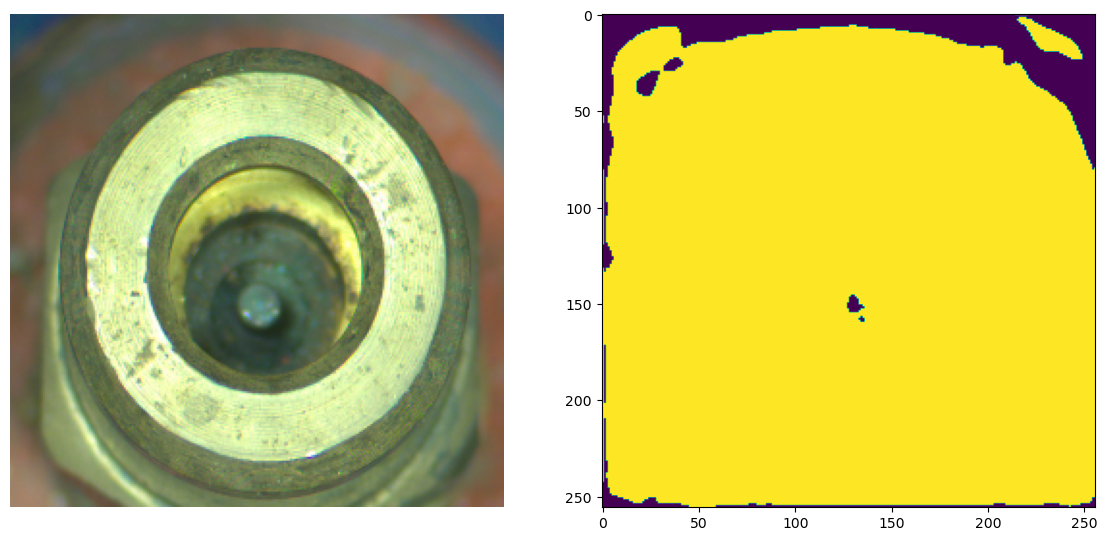

In [4]:
def predict_mask(img_path):
    fig, ax = plt.subplots(1, 2, figsize=(14, 10))
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (IMG_W, IMG_H))
    ax[0].imshow(img)
    ax[0].axis('off')
    img = np.array(img, dtype='float32')
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    img = model.predict(img)
    img = np.squeeze(img, axis=0)
    img = np.round(img)
    img = img * 255.0
    ax[1].imshow(img)
    plt.show()
img_path = r'anomalib\src\anomalib\models\patchcore\patchcore_data2\oring_absent\87.png'
predict_mask(img_path)

1/1 [==============================] - 0s 200ms/step


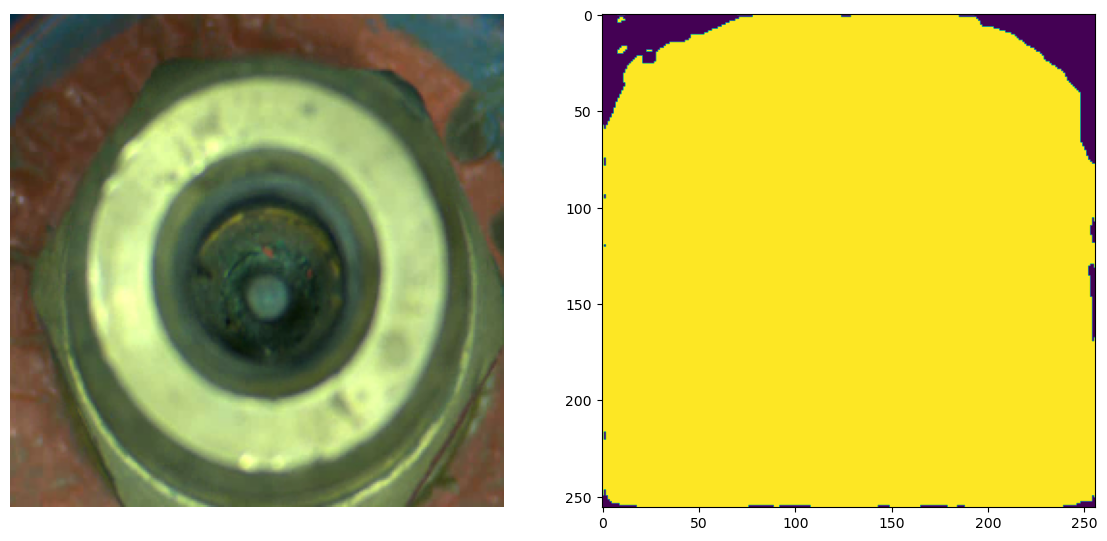

In [5]:
img_path = r'anomalib\src\anomalib\models\patchcore\patchcore_data2\oring_present\yknpcrhjet.png'
predict_mask(img_path)